# Analyze Hyperparameter Sweeps

In [1]:
import pathlib
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from src.util.definitions import PRED_DIR, DATA_ROOT

In [2]:
def get_runs_as_list(project="jugoetz/synferm-predictions", filters={}):
    api = wandb.Api()
    runs = api.runs(project, filters=filters)
    summary_list, config_list, name_list, tag_list = [], [], [], []
    for run in runs:
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)
    
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})
    
        tag_list.append(run.tags)
    
        # .name is the human-readable name of the run.
        name_list.append(run.name)
    return summary_list, config_list, tag_list, name_list

In [3]:
summary_list, config_list, tag_list, name_list = get_runs_as_list(filters={"jobType": "hparam_optimization"})

In [17]:
run_df = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
run_df["tags"] = tag_list

In [18]:
run_df.head()

,name,run_id,run_group,num_labels,accelerator,target_names,data_hash_key,experiment_id,label_binarizer,atom_feature_size,...,val/auroc_target_binary_A,train/auroc_target_binary_B,train/auroc_target_binary_C,train/auroc_macro,val/auroc_target_binary_C,train/auroc_target_binary_A,val/auroc_macro,val/f1_micro,val/auroc_target_binary_B,tags
0,D-MPNN,2023-11-08-215951_812657_fold8,2023-11-08-215951_812657,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1159,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0D_1.25]
1,D-MPNN,2023-11-08-215951_812657_fold7,2023-11-08-215951_812657,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1159,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0D_1.25]
2,D-MPNN,2023-11-08-215951_812657_fold6,2023-11-08-215951_812657,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1159,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0D_1.25]
3,D-MPNN,2023-11-08-215951_812657_fold5,2023-11-08-215951_812657,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1159,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0D_1.25]
4,D-MPNN,2023-11-08-215951_812657_fold4,2023-11-08-215951_812657,3,gpu,"[binary_A, binary_B, binary_C]",511fce28,JG1159,LabelBinarizer(),66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0D_1.25]


In [19]:
# see the unique configurations
architecture_cols = ["name", "tags", "decoder.global_features", "training.task", "experiment_id"]
run_df[architecture_cols].applymap(lambda x: tuple(x) if isinstance(x, list) else x).drop_duplicates().sort_values(by="experiment_id")

,name,tags,decoder.global_features,training.task,experiment_id
10440,D-MPNN,"(0D,)","(None,)",multilabel,JG1100
10260,D-MPNN,"(1D,)","(None,)",multilabel,JG1101
10080,D-MPNN,"(2D,)","(None,)",multilabel,JG1102
9900,D-MPNN,"(3D,)","(None,)",multilabel,JG1103
8910,GCN,"(1D,)","(None,)",multilabel,JG1104
...,...,...,...,...,...
720,D-MPNN,"(0D_20,)","(RDKit,)",multilabel,JG1155
540,D-MPNN,"(0D_10,)","(RDKit,)",multilabel,JG1156
360,D-MPNN,"(0D_5,)","(RDKit,)",multilabel,JG1157
180,D-MPNN,"(0D_2.5,)","(RDKit,)",multilabel,JG1158


In [20]:
# reduce df to columns with differences
nunique = run_df.applymap(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
cols_to_drop = nunique[nunique == 1].index
run_df = run_df.drop(cols_to_drop, axis=1)

In [21]:
# get all runs belonging to a certain hyperparameter sweep
run_df.loc[run_df["experiment_id"] == "JG1111"].columns

Index(['name', 'run_id', 'run_group', 'accelerator', 'data_hash_key',
       'experiment_id', 'global_feature_size', 'decoder.depth',
       'decoder.hidden_size', 'decoder.dropout_ratio',
       'decoder.global_features', 'encoder.depth', 'encoder.graph_type',
       'encoder.hidden_size', 'encoder.dropout_ratio', 'optimizer.lr',
       'optimizer.lr_scheduler.lr_min', 'decoder.gamma', 'decoder.reg_alpha',
       'decoder.reg_lambda', 'decoder.learning_rate',
       'global_featurizer_state_dict_path', 'decoder.C', 'train/f1_macro',
       'val/recall_target_binary_B', 'val/precision_target_binary_C',
       'val/precision_macro', 'train/avgPrecision_macro',
       'train/f1_target_binary_A', 'val/balanced_accuracy_macro',
       'train/precision_target_binary_C', 'train/loss',
       'val/precision_target_binary_A', 'val/avgPrecision_target_binary_B',
       'val/balanced_accuracy_target_binary_A', 'train/precision_macro',
       'train/recall_target_binary_A', 'val/accuracy_target_b

In [30]:
import plotly.graph_objects as go

In [31]:
df_plot = run_df.loc[run_df["experiment_id"] == "JG1116"]

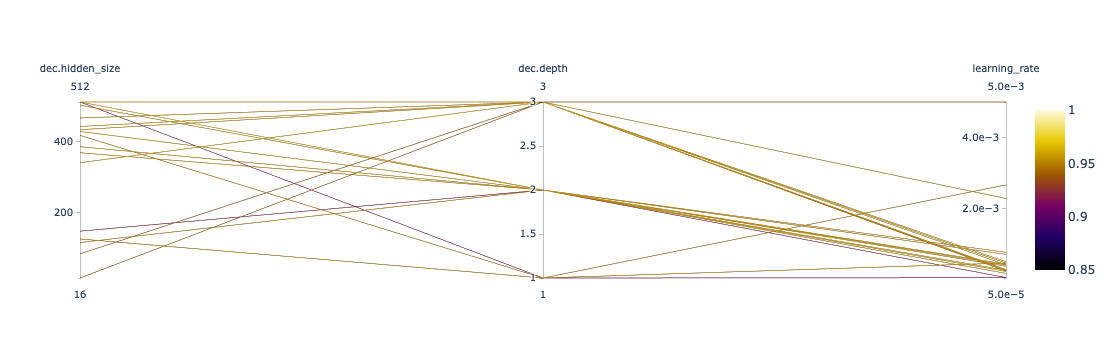

In [47]:
fig = go.Figure(data=
   go.Parcoords(
       line = dict(color = df_plot['val/avgPrecision_macro'],
           colorscale = 'Electric',
           showscale = True,
           cmin = 0.85,
           cmax = 1.0),
       dimensions = list([
           dict(range = [16, 512],
                label = 'dec.hidden_size', values = df_plot['decoder.hidden_size']),
           dict(range = [1, 3],
                label = 'dec.depth', values = df_plot['decoder.depth']),
           dict(range = [5e-5, 5e-3],
                label = 'learning_rate', values = df_plot['optimizer.lr'], tickformat = '.1e'),
           # Add more variables as needed
       ])
   )
)
fig.show()


In [42]:
df_plot['optimizer.lr'].max()

0.004999999999999999

<Axes: >

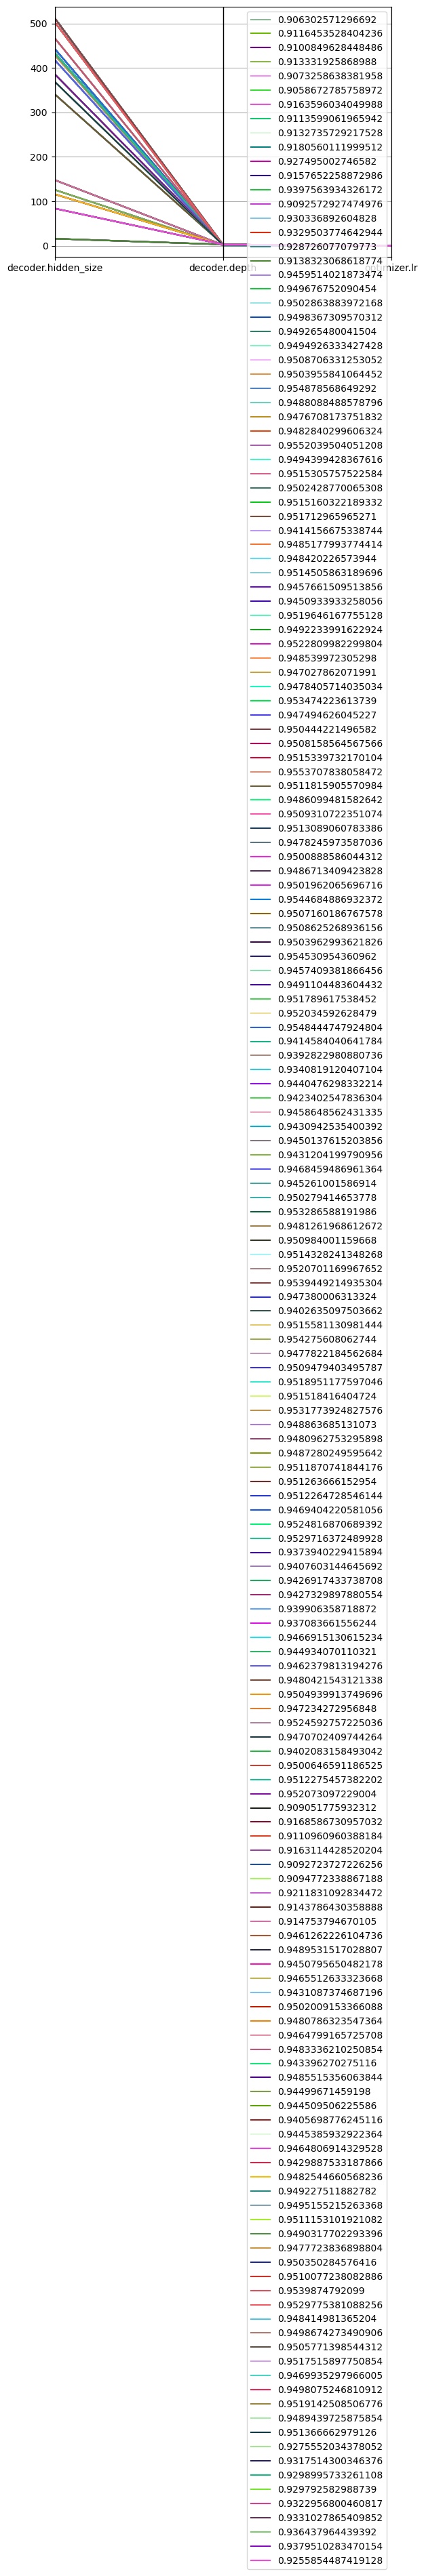

In [28]:
parallel_coordinates(run_df.loc[run_df["experiment_id"] == "JG1116"], class_column="val/avgPrecision_macro", cols=["decoder.hidden_size", "decoder.depth", "optimizer.lr"])

